In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
# file  = "HS_front_RH50_PR0_PRRELAX86400_day0_500_all.dat"
file  = "HS_front_RH50_PR0_PRRELAX86400_with_w_all.dat"

ds = h5py.File(file, "r")
print(ds.keys())

print(np.nanmax(np.asarray(ds["grid_w_full_xyzt"])))
dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
test = np.zeros(u.shape)
print(test.shape)

<KeysViewHDF5 ['_types', 'grid_geopots_xyzt', 'grid_lnp_full_xyzt', 'grid_lnp_half_xyzt', 'grid_lnps_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_xyzt', 'grid_t_c_xyzt', 'grid_t_eq_xyzt', 'grid_tracers_c_xyz1t', 'grid_tracers_diff_xyz1t', 'grid_tracers_n_xyz1t', 'grid_tracers_p_xyz1t', 'grid_u_c_xyzt', 'grid_v_c_xyzt', 'grid_w_full_xyzt', 'grid_Δp_xyzt', 'spe_div_c_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_vor_c_xyzt']>
1.1106318184925956
(500, 20, 64, 128)


In [4]:
def plot_V_W_50(pr):
    file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (ps / p)**(Rd/cp)
    H = 6800
    # p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(u.shape)
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzmtm = np.nanmean(theta, axis=(0,3))
    THETAz  = np.zeros((20,64))
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1])
    THETAz[0,:]  = (THzmtm[1,:]  - THzmtm[0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[-1,:] = (THzmtm[-1,:] - THzmtm[-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(128-1,0,-1):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzmtm = np.nanmean(v, axis=(0,3))
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0 * VTHzmtm / THETAz
    vTEM_tempdz = np.zeros((20,64))
    for i in range(1,19):
        vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[0,:]  = (vTEM_temp[1,:]  - vTEM_temp[0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[-1,:] = (vTEM_temp[-1,:] - vTEM_temp[-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzmtm
    vTEM2 = (1/rho_0) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzmtm / THETAz
    wTEM_tempdphi = np.zeros((20,64))
    for i in range(1,63):
        wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,0]  = (wTEM_temp[:,1] - wTEM_temp[:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,-1] = (wTEM_temp[:,-1] - wTEM_temp[:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzmtm
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2
    
    #############################################################################
    u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    Vzm = np.nanmean(v, axis=3)
    Uzm = np.nanmean(u, axis=3)
    Vza = np.zeros(u.shape)
    Uza = np.zeros(u.shape)
    
    for i in range(0,128):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        Uza[:,:,:,i]     = u[:,:,:,i] - Uzm  
    #############################################################################
    return vTEM,wTEM,p, ps, Wzmtm, rho_0

0


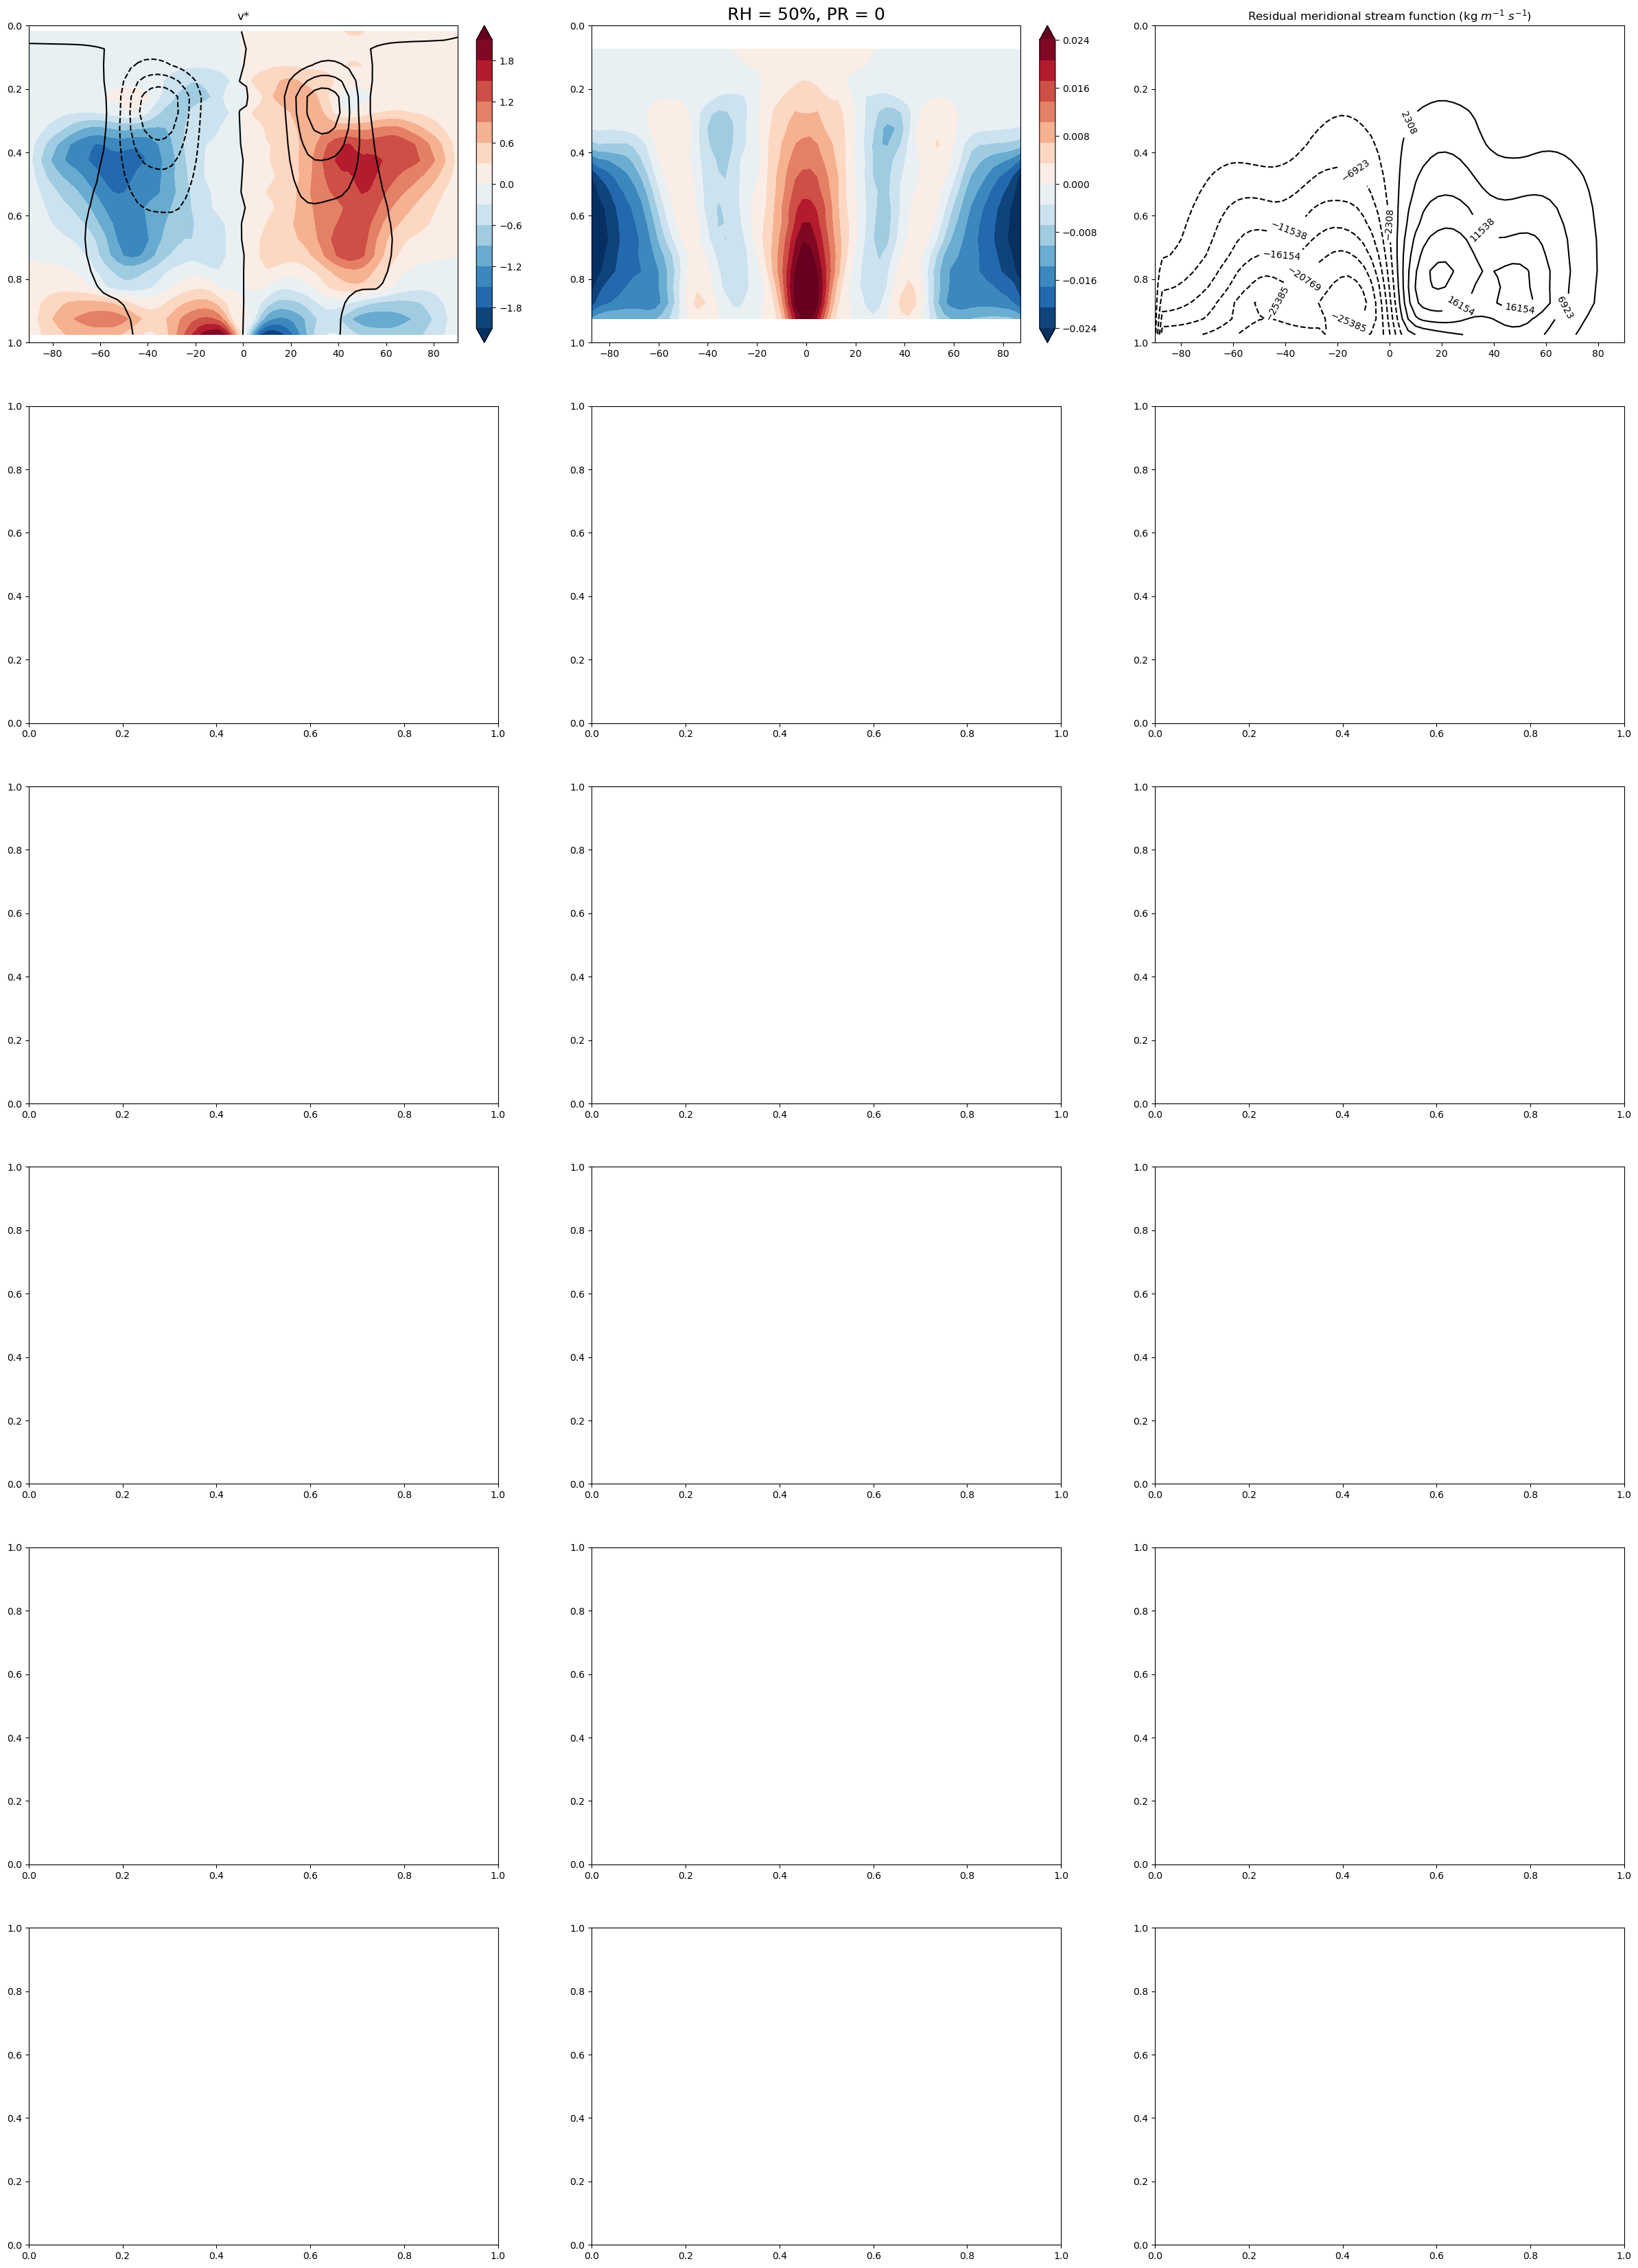

In [5]:
### plot RH = 50
import cmaps
fig, ax = plt.subplots(6, 3, figsize=(30, 42))
for pr in range(0,10,10):
    vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(pr)
    sigma_mean = np.nanmean(p/ps, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    y = np.linspace(-90,90,64)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
    ### residual circulation
    # phi
    a = 6.37122e6
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    cphi  = np.cos(phi) 
    acphi = a * cphi

    psi_w1 = Wzmtm #np.nanmean(w , axis=(0,3))
    psi_w2 = Wzmtm #np.nanmean(w , axis=(0,3))

    psi_w1[:,0] = 0
    for ilat in range(1,64-1):
        dlat = phi[:,ilat] - phi[:,ilat-1]       
        psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])
        # print(psi_w1[:,ilat])

    psi_w2[:,64-1] = 0    
    for jlat in range(1,64-1):
        ilat = 64 - 1 - jlat
        dlat = phi[:,ilat] - phi[:,ilat+1]           
        psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])

    psi_w = 0.5*(psi_w1 + psi_w2)
    ####
    
    ##########################################################################
    x = np.linspace(-180,180,128)
    y = np.linspace(-90,90,64)
    xd = np.deg2rad(x)
    yd = np.deg2rad(y)
    file  = "HS_front_RH50_PR0_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    dycore = Dycore(file)
    u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    Vzm = np.nanmean(v, axis=3)
    Uzm = np.nanmean(u, axis=3)
    Vza = np.zeros(u.shape)
    Uza = np.zeros(u.shape)
    
    for i in range(0,128):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    kk = np.nanmean(Uza * Vza, axis=(0,3))
    dmdy = np.zeros((20,64))
    for i in range(1,64-1):
        dmdy[:,i] = (kk[:,i+1] - kk[:,i-1]) / (yd[i+1] - yd[i-1])
    dmdy[:, 0] = (kk[:, 1] - kk[:, 0]) / (yd[ 1] - yd[ 0])
    dmdy[:,-1] = (kk[:,-1] - kk[:,-2]) / (yd[-1] - yd[-2])
    # ax[int(pr/10),0].contour(yy[:,:], sigma_mean2[:,:], kk, cmap="RdBu_r", extend="both")    
    
    ################################################
    # plot
    print(int(pr/10))
    ### v*
    cs1 = ax[int(pr/10),0].contourf(yy[:,:], sigma_mean2[:,:], vTEM[:,:], levels=np.linspace(-2.1,2.1,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),0].contour(yy[:,:], sigma_mean2[:,:], np.nanmean(Uza * Vza, axis=(0,3)), colors='k')
    
    ax[int(pr/10),0].set_ylim([1,0])
    fig.colorbar(cs1, orientation='vertical', ax=ax[int(pr/10),0],fraction=0.046, pad=0.04)
    ax[int(pr/10),0].set_title("v*")
    ###. w*
    cs2 = ax[int(pr/10),1].contourf(yy[1:-1,1:-1], sigma_mean2[1:-1,1:-1],-wTEM[1:-1,1:-1], levels=np.linspace(-2.4E-2,2.4E-2,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),1].set_ylim([1,0])
    cb2 = fig.colorbar(cs2, orientation='vertical', ax=ax[int(pr/10),1],fraction=0.046, pad=0.04)
    cb2.set_ticks(np.linspace(-2.4E-2,2.4E-2,7))
    ax[int(pr/10),1].set_title("w*")
    ### plot residual
    cs3 = ax[int(pr/10),2].contour(yy,sigma_mean2, -psi_w , levels=np.linspace(-30000,30000,14), colors='k')
    # print(np.nanmax(psi_w), np.nanmin(psi_w))
    ax[int(pr/10),2].clabel(cs3)
    ax[int(pr/10),2].set_ylim([1,0])
    ax[int(pr/10),2].set_title("Residual meridional stream function (kg $m^{-1}$ $s^{-1}$)") #(kg $m^{-1}$ $s^{-1}$) (RH=50, PR=10)
    ax[int(pr/10),1].set_title(f"RH = 50%, PR = {pr}", fontsize=18)
# plt.savefig("plot_RH50_PR0_50_TEM.png", dpi=600., bbox_inches='tight')
plt.show()

(1.0, 0.0)

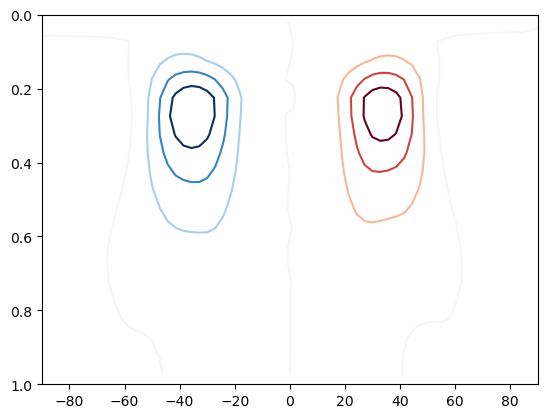

In [6]:
file  = "HS_front_RH50_PR0_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
v  = dycore.getVar("grid_v_c_xyzt")
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
kk = np.nanmean(Uza * Vza, axis=(0,3))
dmdy = np.zeros((20,64))
for i in range(1,64-1):
    dmdy[:,i] = (kk[:,i+1] - kk[:,i-1]) / (yd[i+1] - yd[i-1])
dmdy[:, 0] = (kk[:, 1] - kk[:, 0]) / (yd[ 1] - yd[ 0])
dmdy[:,-1] = (kk[:,-1] - kk[:,-2]) / (yd[-1] - yd[-2])
plt.figure()
plt.contour(yy[:,:], sigma_mean2[:,:], kk, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
